In [ ]:
# Montage de Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importation des bibliothèques
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Définition des chemins d’accès aux fichiers
BASE_PATH = '/content/drive/MyDrive'  # Dossier contenant images + CSV
ANNOTATIONS_PATH = os.path.join(BASE_PATH, 'Dataset_bainem.csv')
DATA_DIR = os.path.join(BASE_PATH, 'images_bainem')
OUTPUT_DIR = os.path.join(BASE_PATH, 'bone_age_project/models')
LOGS_DIR = os.path.join(BASE_PATH, 'bone_age_project/logs')
MODEL_PATH = os.path.join(BASE_PATH, 'bone_age_project/best_model_final9.h5')

# Création des répertoires de sortie s’ils n’existent pas
for directory in [OUTPUT_DIR, LOGS_DIR]:
    os.makedirs(directory, exist_ok=True)

# Définition des hyperparamètres de l’apprentissage
BATCH_SIZE = 8
EPOCHS = 30
LEARNING_RATE = 1e-4
MAX_BONE_AGE = 216.0 # Age max


In [ ]:
# Fonctions de prétraitement des images

# Normalisation de l'intensité des pixels (entre 0 et 1), normalisation avancée: ajuster le contraste
def normalize_intensity(image):
    image = tf.cast(image, tf.float32) / 255.0
    mean = tf.reduce_mean(image)
    std = tf.math.reduce_std(image)

    return (image - mean) / (std + 1e-5)

# Redimensionnement de l'image avec conservation du rapport d'aspect et ajout du remplissage (padding)
def resize_with_pad(image, target_height=224, target_width=224):
    return tf.image.resize_with_pad(image, target_height, target_width)

# Fonction d'augmentation de données
def data_augmentation(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    return image

# Pipeline complet de prétraitement pour une image donnée
def preprocess_image(image_path, augment=True):
    image_str = tf.io.read_file(image_path)
    image = tf.image.decode_png(image_str, channels=1)
    image = normalize_intensity(image)
    image = resize_with_pad(image)
    if augment:
        image = data_augmentation(image)
    return image

# Fonction de création d'un jeu de données structuré à partir d’un DataFrame
def create_dataset(dataframe, batch_size=BATCH_SIZE, augment=True):
    image_paths = [os.path.join(DATA_DIR, f"{id}.png") for id in dataframe['id']]
    ages = dataframe['boneage'].values / MAX_BONE_AGE
    genders = dataframe['male'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, (ages, genders)))
    dataset = dataset.map(lambda x, y: (preprocess_image(x, augment), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(dataframe))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Adaptation du dataset au format d'entrée du modèle
def adapt_dataset_for_model(dataset):
    return dataset.map(lambda x, y: ({"image_input": x, "gender_input": y[1]}, y[0]), num_parallel_calls=tf.data.AUTOTUNE)

# Chargement des données
df = pd.read_csv(ANNOTATIONS_PATH)
df['male'] = df['male'].astype(int)

# Division du jeu de données en trois sous-ensembles : entraînement, validation et test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_ds = adapt_dataset_for_model(create_dataset(train_df, augment=True))
val_ds = adapt_dataset_for_model(create_dataset(val_df, augment=False))
test_ds = adapt_dataset_for_model(create_dataset(test_df, augment=False))

# Chargement du modèle pré-entraîné
model = load_model(MODEL_PATH, compile=False)
model.summary()

# 1. Geler toutes les couches sauf les 20 dernières
for i, layer in enumerate(model.layers):
    if i < len(model.layers) - 50:
        layer.trainable = False
    else:
        layer.trainable = True

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='mse',
              metrics=['mae']  )


# Définition des callbacks
callbacks = [

    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'best_fine_tuning_modelv_1.h5'),
        monitor='val_mae', save_best_only=True, mode='min', verbose=1
    ),

    tf.keras.callbacks.ReduceLROnPlateau( #Learning Rate Dynamique
        monitor='val_mae', factor=0.5, patience=3, min_lr=1e-2, verbose=1
    ),

    tf.keras.callbacks.EarlyStopping(
        monitor='val_mae', patience=5, restore_best_weights=True, verbose=1
    ),

    tf.keras.callbacks.TensorBoard(
        log_dir=os.path.join(LOGS_DIR, datetime.now().strftime("%Y%m%d-%H%M%S")),
        histogram_freq=1
    )
]

# Entraînement du modele
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Sauvegarde finale du modèle affiné
model.save(os.path.join(OUTPUT_DIR, 'final_fine_tuning_modelv_1.h5'))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      1,024 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 12,845,312 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_input        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,277,953 (50.65 MB)

 Trainable params: 13,276,225 (50.64 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/30
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0526 - mae: 0.1554
Epoch 1: val_mae improved from inf to 0.11951, saving model to /content/drive/MyDrive/bone_age_project/models/best_fine_tuning_modelv_1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.0519 - mae: 0.1549 - val_loss: 0.0318 - val_mae: 0.1195 - learning_rate: 1.0000e-04
Epoch 2/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0372 - mae: 0.1236
Epoch 2: val_mae improved from 0.11951 to 0.11885, saving model to /content/drive/MyDrive/bone_age_project/models/best_fine_tuning_modelv_1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 397ms/step - loss: 0.0374 - mae: 0.1241 - val_loss: 0.0347 - val_mae: 0.1189 - learning_rate: 1.0000e-04
Epoch 3/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0377 - mae: 0.1239
Epoch 3: val_mae improved from 0.11885 to 0.10287, saving model to /content/drive/MyDrive/bone_age_project/models/best_fine_tuning_modelv_1.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 28s 682ms/step - loss: 0.0379 - mae: 0.1244 - val_loss: 0.0339 - val_mae: 0.1029 - learning_rate: 1.0000e-04
Epoch 4/30
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0394 - mae: 0.1267
Epoch 4: val_mae did not improve from 0.10287
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 395ms/step - loss: 0.0391 - mae: 0.1258 - val_loss: 0.0476 - val_mae: 0.1492 - learning_rate: 1.0000e-04
Epoch 5/30
15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0398 - mae: 0.1282
Epoch 5: val_mae did not improve from 0.10287
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 436ms/step - loss: 0.0398 - mae: 0.1277 - val_loss: 0.0429 - val_mae: 0.1233 - learning_rate: 1.0000e-04
Epoch 6/30
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0338 - mae: 0.1076
Epoch 6: val_mae did not improve from 0.10287
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 338ms/step - loss: 0.0340 - mae: 0.1082 - val_loss: 0.0536 - val_mae: 0.1581 - learning_rate: 1.0000e-04
Epoch 7/30
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0335 - mae: 0.105

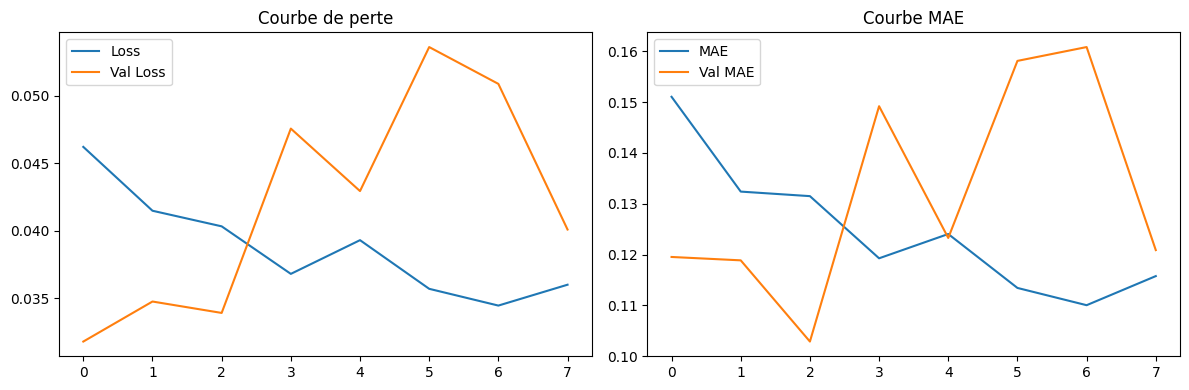

3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 558ms/step - loss: 0.0206 - mae: 0.0669

MAE sur le jeu de test : 12.86 mois
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
Coefficient de corrélation (R): 0.901


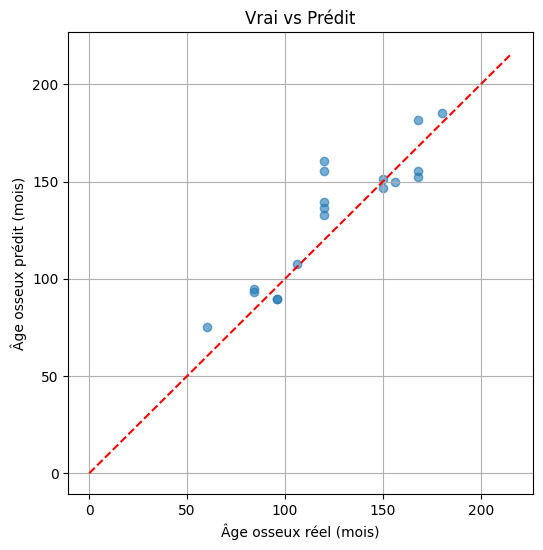

MAE: 12.86 mois
MSE: 16.49 mois
R²: 0.76


In [ ]:
# Visualisation des courbes

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Courbe de perte')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Courbe MAE')

plt.tight_layout()
plt.show()

# Évaluation sur le jeu de test
loss, mae = model.evaluate(test_ds, verbose=1)
print(f"\nMAE sur le jeu de test : {mae * MAX_BONE_AGE:.2f} mois")

# Comparaison entre les prédictions du modèle et les valeurs réelles
y_true = []
y_pred = []

for batch in test_ds:
    inputs, targets = batch
    preds = model.predict(inputs)
    y_true.extend(targets.numpy())
    y_pred.extend(preds.flatten())

# Dénormalisation
y_true = np.array(y_true) * MAX_BONE_AGE
y_pred = np.array(y_pred) * MAX_BONE_AGE

# Calcul et affichage du coefficient de corrélation
from scipy.stats import pearsonr
corr, _ = pearsonr(y_true, y_pred)
print(f"Coefficient de corrélation (R): {corr:.3f}")

# Représentation graphique des résultats (nuage de points)
plt.figure(figsize=(6, 6))

plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([0, MAX_BONE_AGE], [0, MAX_BONE_AGE], 'r--')
plt.xlabel("Âge osseux réel (mois)")
plt.ylabel("Âge osseux prédit (mois)")
plt.title("Vrai vs Prédit")
plt.grid(True)

plt.show()

# Calcul des métriques
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f} mois")
print(f"MSE: {rmse:.2f} mois")
print(f"R²: {r2:.2f}")